In [1]:
import IJulia

# The julia kernel has built in support for Revise.jl, so this is the 
# recommended approach for long-running sessions:
# https://github.com/JuliaLang/IJulia.jl/blob/9b10fa9b879574bbf720f5285029e07758e50a5e/src/kernel.jl#L46-L51

# Users should enable revise within .julia/config/startup_ijulia.jl:
# https://timholy.github.io/Revise.jl/stable/config/#Using-Revise-automatically-within-Jupyter/IJulia-1

# clear console history
IJulia.clear_history()

fig_width = 7
fig_height = 5
fig_format = :retina
fig_dpi = 96

# no retina format type, use svg for high quality type/marks
if fig_format == :retina
  fig_format = :svg
elseif fig_format == :pdf
  fig_dpi = 96
  # Enable PDF support for IJulia
  IJulia.register_mime(MIME("application/pdf"))
end

# convert inches to pixels
fig_width = fig_width * fig_dpi
fig_height = fig_height * fig_dpi

# Intialize Plots w/ default fig width/height
try
  import Plots

  # Plots.jl doesn't support PDF output for versions < 1.28.1
  # so use png (if the DPI remains the default of 300 then set to 96)
  if (Plots._current_plots_version < v"1.28.1") & (fig_format == :pdf)
    Plots.gr(size=(fig_width, fig_height), fmt = :png, dpi = fig_dpi)
  else
    Plots.gr(size=(fig_width, fig_height), fmt = fig_format, dpi = fig_dpi)
  end
catch e
  # @warn "Plots init" exception=(e, catch_backtrace())
end

# Initialize CairoMakie with default fig width/height
try
  import CairoMakie
  
  CairoMakie.activate!(type = string(fig_format))
  CairoMakie.update_theme!(resolution=(fig_width, fig_height))
catch e
    # @warn "CairoMakie init" exception=(e, catch_backtrace())
end
  
# Set run_path if specified
try
  run_path = raw"/home/diego/local_repos/AGEC652_2024/slides/lecture_7_2"
  if !isempty(run_path)
    cd(run_path)
  end
catch e
  @warn "Run path init:" exception=(e, catch_backtrace())
end


# emulate old Pkg.installed beahvior, see
# https://discourse.julialang.org/t/how-to-use-pkg-dependencies-instead-of-pkg-installed/36416/9
import Pkg
function isinstalled(pkg::String)
  any(x -> x.name == pkg && x.is_direct_dep, values(Pkg.dependencies()))
end

# ojs_define
if isinstalled("JSON") && isinstalled("DataFrames")
  import JSON, DataFrames
  global function ojs_define(; kwargs...)
    convert(x) = x
    convert(x::DataFrames.AbstractDataFrame) = Tables.rows(x)
    content = Dict("contents" => [Dict("name" => k, "value" => convert(v)) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
elseif isinstalled("JSON")
  import JSON
  global function ojs_define(; kwargs...)
    content = Dict("contents" => [Dict("name" => k, "value" => v) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
else
  global function ojs_define(; kwargs...)
    @warn "JSON package not available. Please install the JSON.jl package to use ojs_define."
  end
end


# don't return kernel dependencies (b/c Revise should take care of dependencies)
nothing


In [2]:
#| include: false
using Pkg
Pkg.activate(".")
Pkg.instantiate()
Pkg.add("Optim")
Pkg.add("GLM")
Pkg.add("LinearAlgebra")
Pkg.add("Plots")
Pkg.add("LaTeXStrings")
Pkg.add("DataFrames")
Pkg.add("CSV")

  Activating project at `~/local_repos/AGEC652_2024/slides/lecture_7_2`


   Resolving package versions...


  No Changes to `~/local_repos/AGEC652_2024/slides/lecture_7_2/Project.toml`
  No Changes to `~/local_repos/AGEC652_2024/slides/lecture_7_2/Manifest.toml`


   Resolving package versions...


  No Changes to `~/local_repos/AGEC652_2024/slides/lecture_7_2/Project.toml`
  No Changes to `~/local_repos/AGEC652_2024/slides/lecture_7_2/Manifest.toml`


   Resolving package versions...


  No Changes to `~/local_repos/AGEC652_2024/slides/lecture_7_2/Project.toml`
  No Changes to `~/local_repos/AGEC652_2024/slides/lecture_7_2/Manifest.toml`


   Resolving package versions...


  No Changes to `~/local_repos/AGEC652_2024/slides/lecture_7_2/Project.toml`
  No Changes to `~/local_repos/AGEC652_2024/slides/lecture_7_2/Manifest.toml`


   Resolving package versions...


  No Changes to `~/local_repos/AGEC652_2024/slides/lecture_7_2/Project.toml`
  No Changes to `~/local_repos/AGEC652_2024/slides/lecture_7_2/Manifest.toml`


   Resolving package versions...


  No Changes to `~/local_repos/AGEC652_2024/slides/lecture_7_2/Project.toml`
  No Changes to `~/local_repos/AGEC652_2024/slides/lecture_7_2/Manifest.toml`


   Resolving package versions...


  No Changes to `~/local_repos/AGEC652_2024/slides/lecture_7_2/Project.toml`
  No Changes to `~/local_repos/AGEC652_2024/slides/lecture_7_2/Manifest.toml`


In [3]:
using DataFrames, CSV
df = CSV.read("data/duopoly_shares_data.csv", DataFrame)

Row,MarketID,s_k,p_k,s_0,steel,labor,product
,Int64,Float64,Float64,Float64,Float64,Float64,String1
1,1,0.0349996,36.0954,0.897339,7.6,20.24,a
2,1,0.0676614,34.7954,0.897339,7.6,20.24,b
3,2,0.0430019,31.25,0.867155,8.83,21.91,a
4,2,0.0898428,33.24,0.867155,8.83,21.91,b
5,3,0.0183532,41.1012,0.891106,7.13,22.75,a
6,3,0.090541,36.1912,0.891106,7.13,22.75,b
7,4,0.0470709,34.8443,0.854786,7.43,21.11,a
8,4,0.0981434,34.7843,0.854786,7.43,21.11,b
9,5,0.0486621,32.52,0.864966,9.09,21.05,a


In [4]:
N = nrow(df); # Get number of rows
df.logsk_logs0 = log.(df.s_k) - log.(df.s_0); # Calculate LHS of demand equation
df.is_B = (df.product .== "b"); # Create dummy variable for product B
df[1:5,:]  # Check first rows

Row,MarketID,s_k,p_k,s_0,steel,labor,product,logsk_logs0,is_B
,Int64,Float64,Float64,Float64,Float64,Float64,String1,Float64,Bool
1,1,0.0349996,36.0954,0.897339,7.6,20.24,a,-3.2441,false
2,1,0.0676614,34.7954,0.897339,7.6,20.24,b,-2.58492,true
3,2,0.0430019,31.25,0.867155,8.83,21.91,a,-3.00397,false
4,2,0.0898428,33.24,0.867155,8.83,21.91,b,-2.26716,true
5,3,0.0183532,41.1012,0.891106,7.13,22.75,a,-3.88266,false


In [5]:
X = [ones(N) df.p_k df.is_B];
Z = [ones(N) df.is_B df.steel df.labor];

In [6]:
function g_i(θ)
    # DEMAND SIDE
    θ_d = θ[1:3] # Demand parameters
    # Epsilons for demand side
    ϵ_d = df.logsk_logs0 - (X * θ_d) 
    # Moment conditions for demand side
    m_di = Z .* ϵ_d

    # SUPPLY SIDE
    # Calculate implied costs
    α = -θ[2] # We need it to recover costs
    c_k = df.p_k - 1/α .* 1 ./(1 .- df.s_k)

    θ_s = θ[4:7] # Supply parameters
    # Epsilons for supply side
    ϵ_s = c_k - (Z * θ_s)
    # Moment conditions for supply side
    m_si = Z .* ϵ_s
  
    # Return matrices side by side (N x M)
    return([m_di m_si])
end;

In [7]:
using LinearAlgebra
M = 8 # Eight moment conditions
W_0 = I(M) # Identity Matrix
function Q(θ; W = W_0)
    # Get moment vectors
    m_i = g_i(θ)
    # Take means of each column
    G = [sum(m_i[:, k]) for k in 1:M] ./ N
    # Calculate Q    
    G' * W * G
end;

In [8]:
using GLM
# OLS regression to get initial guess
ols_reg = lm(@formula(logsk_logs0 ~ 1 + p_k + is_B), df);
θ_0 = [coef(ols_reg); minimum(df.p_k); ones(3)./10];
θ_0'

1×7 adjoint(::Vector{Float64}) with eltype Float64:
 0.59417  -0.102303  0.611992  29.5715  0.1  0.1  0.1

In [9]:
# Step 1
using Optim
res = Optim.optimize(Q, θ_0, Newton(), Optim.Options(f_abstol=1e-10, g_abstol=0.0, g_reltol=0.0))
θ_1 =  res.minimizer;
θ_1'

1×7 adjoint(::Vector{Float64}) with eltype Float64:
 0.607455  -0.102708  0.612948  18.7229  0.215997  0.2718  0.154902

In [10]:
# Calculate W_hat
W = inv(g_i(θ_1)'  * g_i(θ_1) ./N)

8×8 Matrix{Float64}:
 22645.8      -115.444     …  -23.0081     -5.69782     1.41266
  -115.444     177.383         -2.95534     0.226009    0.885507
  -447.324       1.85469        0.179547    0.400217    0.262554
  -857.543       0.832448       0.896556    0.120697   -0.194816
    30.8689    -22.9306         1.1218     -1.97982    -6.6906
   -23.0081     -2.95534   …    2.02458    -0.162135   -0.0151455
    -5.69782     0.226009      -0.162135    0.291764   -0.0127074
     1.41266     0.885507      -0.0151455  -0.0127074   0.308547

In [11]:
# Use step 1 estimates as initial guess
res = Optim.optimize(Q, θ_1, Newton(), Optim.Options(f_abstol=1e-10, g_abstol=0.0, g_reltol=0.0))
θ_GMM =  res.minimizer;
θ_GMM'

1×7 adjoint(::Vector{Float64}) with eltype Float64:
 0.611541  -0.102827  0.613015  18.7344  0.216421  0.271794  0.154919

In [12]:
α_hat = -θ_GMM[2];
df.c_k = df.p_k - 1/α_hat .* 1 ./(1 .- df.s_k);

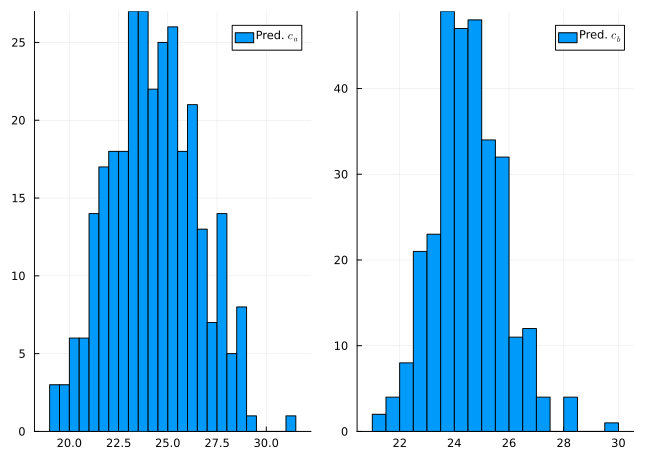

In [13]:
using Plots, LaTeXStrings
plot(histogram(df.c_k[.!df.is_B], label=L"Pred. $c_a$", bins=30), histogram(df.c_k[df.is_B], label=L"Pred. $c_b$", bins=30))

In [14]:
df.lerner_k = (df.p_k - df.c_k) ./ df.p_k;
# Firm A
mean_lerner_a = sum(df.lerner_k[.!df.is_B])./(N/2);
# Firm B
mean_lerner_b = sum(df.lerner_k[df.is_B])./(N/2);
println("The mean Lerner index of firm A is $(round(mean_lerner_a, digits=4)) and for firm B is $(round(mean_lerner_b, digits=4))")

The mean Lerner index of firm A is 0.2974 and for firm B is 0.302
